# Multivariate TimeSeries Using Tensorflow

In [110]:
#importing necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

In [111]:
#reading the csv file into pandas data frame
data = pd.read_csv("hd_gm_fixed.csv")

In [112]:
#setting the Date column as the index of the data frame
data['DATE'] = data['date_snap'].apply(pd.to_datetime)
data.set_index('date_snap',inplace=True)

In [113]:
#selecting only those rows, which has Region as 'CENTRAL'
df = data.loc[data['rgn_nm']=='CENTRAL']

In [114]:
df.head()

,STR_ALIAS,weekly_sales_amt,weekly_shrink_amount,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state,DATE
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2/6/17,1695,401262.10,5306.29,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201601,201701,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,...,0.265638,0.13595,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224,IL,2017-02-06
2/13/17,1695,443399.25,5863.51,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201602,201702,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,...,0.265277,0.13595,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224,IL,2017-02-13
2/20/17,1695,511582.18,6765.16,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201603,201703,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,...,0.264662,0.13595,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224,IL,2017-02-20
2/27/17,1695,516735.14,6833.31,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201604,201704,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,...,0.263804,0.13595,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224,IL,2017-02-27
3/6/17,1695,472573.62,6249.31,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,8.9,4.4,201605,201705,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,...,0.263169,0.13595,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224,IL,2017-03-06


In [115]:
df.describe()

,STR_ALIAS,weekly_sales_amt,weekly_shrink_amount,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,rsn_33_rt,...,inval_sls_intrvntn_rt,inval_unt_intrvntn_rt,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate
count,4910.000000,4.910000e+03,4910.000000,4.910000e+03,4.910000e+03,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4.910000e+03,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,...,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.00000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000,4910.0,4910.0,4910.000000,4910.000000,4910.000000,4910.000000,4910.000000
mean,1996.259674,7.059695e+05,12875.233163,7.960894e+05,4.522430e+07,2.624033,65.688595,0.267821,0.319348,0.150102,0.625458,0.224440,9.743218,4.798391,201778.984725,201878.695316,5.348473,3.381797e+07,-0.147151,0.094157,0.013276,0.000791,0.000718,0.000091,0.005471,0.004887,0.000651,0.000483,0.017983,0.002094,0.002021,0.000757,0.000073,0.000439,0.002772,0.001366,0.002182,0.012954,0.011767,-0.000288,...,0.319838,0.275851,0.199463,0.141478,0.050798,0.027715,0.000676,0.449820,0.183206,0.710025,0.289975,0.010114,0.192171,5.088039,13.457882,0.552457,1.43442,1772.693067,16.534216,2873.646257,3.029532,1820.408434,7.462118,2850.914018,0.301426,115.532857,4.524236,1382.167670,0.894705,2.053157,0.872301,2.596334,1.640774,0.0,0.0,400.459711,471.892261,0.850799,60757.533401,0.018195
std,429.215393,2.498609e+05,7104.345234,4.239324e+05,1.718530e+07,0.852777,21.921408,0.442869,0.466272,0.357208,0.484054,0.417255,3.424326,2.378766,99.360350,99.225935,17.895596,1.148161e+07,0.018536,0.008422,0.004197,0.000526,0.000196,0.000109,0.001370,0.001347,0.000402,0.000159,0.006661,0.000776,0.000769,0.000502,0.000060,0.000536,0.001062,0.002044,0.002273,0.002192,0.007604,0.000206,...,0.028811,0.030114,0.069911,0.081264,0.015642,0.004056,0.000526,0.055525,0.045110,0.072496,0.072496,0.003004,0.083285,1.321196,1.924471,0.097276,1.80154,4487.758527,43.610528,6355.201470,6.548699,3520.127339,16.254736,5331.612446,0.912542,451.588907,15.109545,4071.527807,0.306965,1.317195,0.333788,2.002643,1.193319,0.0,0.0,187.774076,226.817605,0.033344,3073.390454,0.008594
min,1695.000000,2.266432e+05,1683.110000,2.733353e+05,2.238652e+07,1.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000,3.500000,201601.000000,201701.000000,0.000000,2.040622e+06,-0.219320,0.070823,0.005784,-0.000348,0.000310,-0.000001,0.002648,0.002171,0.000032,0.000182,-0.094894,0.000459,0.000448,0.000152,-0.000006,-0.000127,0.001210,0.000357,0.000532,0.007027,0.002052,-0.001197,...,0.148539,0.068548,0.073992,0.000002,0.028851,0.011669,0.000025,0.309334,0.062795,0.524279,0.111897,0

In [116]:
df.head

<bound method NDFrame.head of            STR_ALIAS  weekly_sales_amt  ...  state       DATE
date_snap                               ...                  
2/6/17          1695         401262.10  ...     IL 2017-02-06
2/13/17         1695         443399.25  ...     IL 2017-02-13
2/20/17         1695         511582.18  ...     IL 2017-02-20
2/27/17         1695         516735.14  ...     IL 2017-02-27
3/6/17          1695         472573.62  ...     IL 2017-03-06
...              ...               ...  ...    ...        ...
6/17/19         2984         402019.86  ...     MO 2019-06-17
6/24/19         2984         402019.86  ...     MO 2019-06-24
7/1/19          2984         402019.86  ...     MO 2019-07-01
7/8/19          2984         402019.86  ...     MO 2019-07-08
7/15/19         2984         402019.86  ...     MO 2019-07-15

[4910 rows x 142 columns]>

In [117]:
#check the quantity of null values in each columns
df.isnull().sum()

STR_ALIAS               0
weekly_sales_amt        0
weekly_shrink_amount    0
ty_net_shrink           0
ty_inv_sls              0
                       ..
online_sat_voc_pct      0
zip_code                0
shrink_rate             0
state                   0
DATE                    0
Length: 142, dtype: int64

In [118]:
print(df.columns.tolist())

['STR_ALIAS', 'weekly_sales_amt', 'weekly_shrink_amount', 'ty_net_shrink', 'ty_inv_sls', 'inv_cnt', 'cycle_length', 'FET_FLG', 'LU_FLG', 'urban', 'suburban', 'rural', 'rgn_nm', 'us_unemployment_rate_16_24', 'us_unemployment_rate', 'fyfw_prd_bgn', 'fyfw_prd_end', 'str_fet_wk_cnt', 'net_sls_amt', 'rtn_amt_rt', 'rtn_trans_rt', 'mkup_rt', 'rsn_01_rt', 'rsn_02_rt', 'dc_dmg_rt', 'str_dmg_rt', 'cust_sat_rt', 'rsn_06_rt', 'str_use_rt', 'rsn_09_rt', 'rdtag_rt', 'rsn_12_rt', 'rsn_15_rt', 'rsn_18_rt', 'rsn_22_rt', 'rsn_23_rt', 'rsn_24_rt', 'rsn_25_rt', 'promo_rt', 'rsn_30_rt', 'rsn_33_rt', 'rsn_40_rt', 'rsn_41_rt', 'rsn_48_rt', 'rsn_49_rt', 'pc_rsn_24_rt', 'pc_rsn_25_rt', 'pc_rsn_27_rt', 'cull_mkdn_rt', 'rtv_crt_retl', 'rtv_del_retl', 'avg_inv_turns', 'yr_inv_turns', 'clear_inv_pct', 'ops_net_oh_unt_qty', 'ops_net_oh_retl_amt', 'theft_net_oh_unt_qty', 'theft_net_oh_retl_amt', 'net_oh_unt_qty', 'net_oh_retl_amt', 'net_adj_freq', 'neg_oh_unt_qty', 'neg_oh_retl_amt', 'neg_adj_freq', 'port_pwr_net_oh

In [119]:
#drop unnecessary columns
#df = df.drop(columns=['column1','column2','colunm3'])

In [120]:
#fill the null rows with the mean of respective columns
# df = df.fillna(df.mean()) Not needed since HD supplied clean data

# Components of a Time Series

In [121]:
df_1695 = df.loc[df['STR_ALIAS']==1695]
df_1695.head()

,STR_ALIAS,weekly_sales_amt,weekly_shrink_amount,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state,DATE
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2/6/17,1695,401262.10,5306.29,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201601,201701,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,...,0.265638,0.13595,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224,IL,2017-02-06
2/13/17,1695,443399.25,5863.51,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201602,201702,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,...,0.265277,0.13595,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224,IL,2017-02-13
2/20/17,1695,511582.18,6765.16,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201603,201703,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,...,0.264662,0.13595,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224,IL,2017-02-20
2/27/17,1695,516735.14,6833.31,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201604,201704,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,...,0.263804,0.13595,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224,IL,2017-02-27
3/6/17,1695,472573.62,6249.31,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,8.9,4.4,201605,201705,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,...,0.263169,0.13595,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224,IL,2017-03-06


In [122]:
df_1695.dtypes

STR_ALIAS                        int64
weekly_sales_amt               float64
weekly_shrink_amount           float64
ty_net_shrink                  float64
ty_inv_sls                     float64
                             ...      
online_sat_voc_pct             float64
zip_code                         int64
shrink_rate                    float64
state                           object
DATE                    datetime64[ns]
Length: 142, dtype: object

In [123]:
df_1695["weekly_shrink_amount"] = df_1695["weekly_shrink_amount"].astype(float).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
df_1695.head()

,STR_ALIAS,weekly_sales_amt,weekly_shrink_amount,ty_net_shrink,ty_inv_sls,inv_cnt,cycle_length,FET_FLG,LU_FLG,urban,suburban,rural,rgn_nm,us_unemployment_rate_16_24,us_unemployment_rate,fyfw_prd_bgn,fyfw_prd_end,str_fet_wk_cnt,net_sls_amt,rtn_amt_rt,rtn_trans_rt,mkup_rt,rsn_01_rt,rsn_02_rt,dc_dmg_rt,str_dmg_rt,cust_sat_rt,rsn_06_rt,str_use_rt,rsn_09_rt,rdtag_rt,rsn_12_rt,rsn_15_rt,rsn_18_rt,rsn_22_rt,rsn_23_rt,rsn_24_rt,rsn_25_rt,promo_rt,rsn_30_rt,...,cash_pen,sco_pen,key_sku_rt,qty_key_rt,gen_sku_rt,d90_cash_vs_total,d90_sco_vs_total,d90_cash_vs_main,d90_sco_vs_main,attr_rt,quick_term_rt,avg_tenure,avg_wage,pt_ratio,int_cnt,int_val,ext_cnt,ext_val,known_theft_cnt,known_theft_val,merch_recov_cnt,merch_recov_val,pos_recov_cnt,pos_recov_val,risk_avt_cnt,risk_avt_val,lowes_flag,lowes_cnt,menards_flag,menards_cnt,avg_osha_rt,aci_score,cap_index,online_sat_voc_num,online_sat_voc_den,online_sat_voc_pct,zip_code,shrink_rate,state,DATE
date_snap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2/6/17,1695,401262.10,5306,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201601,201701,0,2144252.61,-0.127144,0.087304,0.010206,0.000258,0.000916,0.000890,0.008279,0.005063,0.000202,0.002054,0.020933,0.003653,0.003540,0.001073,0.000113,0.000929,0.004643,0.000458,0.001664,0.023535,0.008267,...,0.265638,0.13595,0.057604,0.022388,0.000174,0.435454,0.138769,0.758336,0.241664,0.011916,0.161290,3.809615,12.522692,0.525192,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,147.17,182,0.808626,62226,0.013224,IL,2017-02-06
2/13/17,1695,443399.25,5863,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201602,201702,0,2541467.58,-0.132816,0.087479,0.009921,0.000389,0.000902,0.000786,0.007966,0.005026,0.000176,0.001815,0.018852,0.003378,0.003283,0.001277,0.000095,0.000792,0.004474,0.000503,0.001455,0.021416,0.008125,...,0.265277,0.13595,0.057042,0.022856,0.000176,0.435300,0.138563,0.758543,0.241457,0.011912,0.161290,3.819231,12.539423,0.525962,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,150.99,188,0.803138,62226,0.013224,IL,2017-02-13
2/20/17,1695,511582.18,6765,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201603,201703,0,2979359.64,-0.127377,0.087550,0.009979,0.000374,0.001134,0.000682,0.007677,0.004845,0.000150,0.001591,0.017222,0.003249,0.003167,0.001271,0.000081,0.000676,0.004450,0.000519,0.001357,0.019718,0.007216,...,0.264662,0.13595,0.056994,0.023444,0.000182,0.436416,0.137728,0.760115,0.239885,0.012488,0.153846,3.829038,12.550192,0.526346,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,153.99,191,0.806230,62226,0.013224,IL,2017-02-20
2/27/17,1695,516735.14,6833,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,10.1,4.6,201604,201704,0,3483103.86,-0.125558,0.087582,0.013030,0.000337,0.001073,0.000645,0.007593,0.004816,0.000130,0.001465,0.016843,0.002940,0.002871,0.001192,0.000069,0.000578,0.004375,0.000481,0.001263,0.018318,0.006822,...,0.263804,0.13595,0.057024,0.023483,0.000178,0.437521,0.137139,0.761356,0.238644,0.012670,0.151515,3.840000,12.560577,0.526154,1,57.21,1,248.98,5,1406.61,4,1316.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,154.77,192,0.806094,62226,0.013224,IL,2017-02-27
3/6/17,1695,472573.62,6249,369874.89,27969203.9,4,55,0,0,0,1,0,CENTRAL,8.9,4.4,201605,201705,0,3995810.51,-0.127151,0.087484,0.012524,0.000327,0.001040,0.000594,0.007134,0.004859,0.000139,0.001316,0.016958,0.002805,0.002744,0.001149,0.000061,0.000504,0.004124,0.000457,0.001273,0.017076,0.006588,...,0.263169,0.13595,0.057089,0.023445,0.000184,0.438268,0.136946,0.761922,0.238078,0.012666,0.151515,3.850385,12.570577,0.525769,1,57.21,1,248.98,4,1277.61,3,917.49,0,0.0,1,388.0,1,2,1,1,1.557512,0,0,159.85,199,0.803266,62226,0.013224,IL,2017-03-06


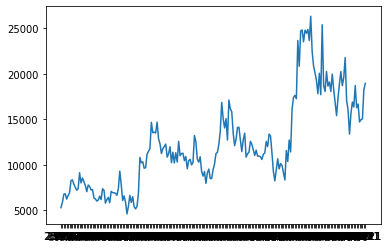

In [125]:
from statsmodels.graphics.tsaplots import plot_acf

plt.plot(df_1695['weekly_shrink_amount'])
plt.show()


Text(0.5, 1.0, 'weekly_shrink_amount')

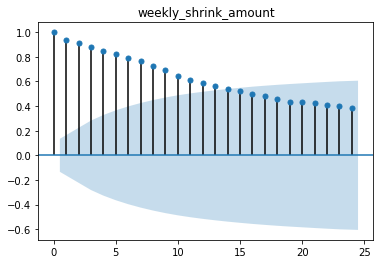

In [126]:
plot_acf(df_1695['weekly_shrink_amount'])
plt.title('weekly_shrink_amount')

In [127]:
# Autocorrelation
# An autocorrelation function measures the degree of similarity of the present series with that of its lagged series (past values). 
# The ACF graph for the AQI index shows spike above the blue region, which is an indication that the series is autocorrelated.
# It means the correlation of the present values with its past values.

In [128]:
df_1695_drop = df_1695.drop(columns=['state','rgn_nm','fyfw_prd_bgn','fyfw_prd_end','DATE'])

In [129]:
len(df_1695)

213

In [130]:
#We will use it further to show the graph of multi step prediction
df_train = df_1695_drop.iloc[0:170]
df_test = df_1695_drop.iloc[170:]

In [154]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# johan_test = df_1695_drop
# coint_johansen(johan_test,-1,1).eig

#https://neeva.com/search?q=---%3E+88+raise+LinAlgError(%22Singular+matrix%22)&src=nvobar#animatedtechdoc-https%3A%2F%2Fstackoverflow.com%2Fquestions%2F44305456%2Fwhy-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests-https%3A%2F%2Fstackoverflow.com%2Fquestions%2F44305456%2Fwhy-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests%23825367011208 

# LSTM

# Data preparation


In [132]:
#scale the values
df_1695_drop = df_1695_drop.values
scaler = MinMaxScaler(feature_range=(0, 1))
df_1695_drop = scaler.fit_transform(df_1695_drop)

In [133]:
print(df_1695_drop)

[[0.         0.07719849 0.0316231  ... 0.09747269 0.         0.        ]
 [0.         0.139927   0.05729959 ... 0.02171492 0.         0.        ]
 [0.         0.24142919 0.09887982 ... 0.06439803 0.         0.        ]
 ...
 [0.         0.34923396 0.48075416 ... 0.06854265 0.         1.        ]
 [0.         0.53228296 0.62679205 ... 0.08801933 0.         1.        ]
 [0.         0.57448771 0.66048956 ... 0.07100321 0.         1.        ]]


In [134]:
#divide the data into train and test data
train_size = int(len(df_1695_drop) * 0.80)
test_size = len(df_1695_drop) - train_size
train, test = df_1695_drop[0:train_size,:], df_1695_drop[train_size:len(df_1695_drop),:]

In [135]:
print(df_1695_drop)

[[0.         0.07719849 0.0316231  ... 0.09747269 0.         0.        ]
 [0.         0.139927   0.05729959 ... 0.02171492 0.         0.        ]
 [0.         0.24142919 0.09887982 ... 0.06439803 0.         0.        ]
 ...
 [0.         0.34923396 0.48075416 ... 0.06854265 0.         1.        ]
 [0.         0.53228296 0.62679205 ... 0.08801933 0.         1.        ]
 [0.         0.57448771 0.66048956 ... 0.07100321 0.         1.        ]]


In [136]:
#index the data into dependent and independent variables
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 136) (170,) (43, 136) (43,)


In [137]:
#convert data into suitable dimension for using it as input in LSTM network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(170, 1, 136) (170,) (43, 1, 136) (43,)


In [138]:
model = Sequential()
model.add(LSTM(250, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [139]:
history = model.fit(train_X, train_y, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/250
3/3 - 2s - loss: 0.4042 - val_loss: 0.5634
Epoch 2/250
3/3 - 0s - loss: 0.1235 - val_loss: 0.0974
Epoch 3/250
3/3 - 0s - loss: 0.2771 - val_loss: 0.0881
Epoch 4/250
3/3 - 0s - loss: 0.1387 - val_loss: 0.2610
Epoch 5/250
3/3 - 0s - loss: 0.1516 - val_loss: 0.1674
Epoch 6/250
3/3 - 0s - loss: 0.1243 - val_loss: 0.0261
Epoch 7/250
3/3 - 0s - loss: 0.1264 - val_loss: 0.0802
Epoch 8/250
3/3 - 0s - loss: 0.1032 - val_loss: 0.0135
Epoch 9/250
3/3 - 0s - loss: 0.0941 - val_loss: 0.0415
Epoch 10/250
3/3 - 0s - loss: 0.0778 - val_loss: 0.0318
Epoch 11/250
3/3 - 0s - loss: 0.0807 - val_loss: 0.0339
Epoch 12/250
3/3 - 0s - loss: 0.0720 - val_loss: 0.0201
Epoch 13/250
3/3 - 0s - loss: 0.0705 - val_loss: 0.0192
Epoch 14/250
3/3 - 0s - loss: 0.0713 - val_loss: 0.0274
Epoch 15/250
3/3 - 0s - loss: 0.0697 - val_loss: 0.0459
Epoch 16/250
3/3 - 0s - loss: 0.0658 - val_loss: 0.0465
Epoch 17/250
3/3 - 0s - loss: 0.0601 - val_loss: 0.0323
Epoch 18/250
3/3 - 0s - loss: 0.0606 - val_loss: 0.0205
E

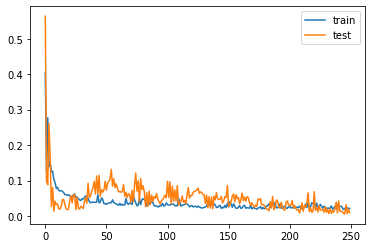

In [140]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [141]:
#prediction on training and testing data
train_predict = model.predict(train_X)    
test_predict = model.predict(test_X)

In [142]:
#converting from three dimension to two dimension
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

In [143]:
#transforming to original scale
inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict)

In [144]:
#predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict

array([1695.01900443, 1695.01725331, 1695.01202008, 1695.02108536,
       1695.01001376, 1695.01426303, 1695.01263027, 1695.01210712,
       1695.01160608, 1695.01531556, 1695.01922398, 1695.01749928,
       1695.01738901, 1695.02255468, 1695.00693043, 1695.01008776,
       1695.00715915, 1695.02667818, 1695.01879796, 1695.01723096,
       1695.01881826, 1695.02144883, 1695.02062936, 1695.00562559,
       1695.00877548, 1695.01363817, 1695.01561641, 1695.01936367,
       1695.01881831, 1695.0277903 , 1695.01361351, 1695.00368966,
       1695.01913825, 1695.02666125, 1695.0198478 , 1695.02487761,
       1695.0245067 , 1695.0276714 , 1695.03080553, 1695.01310358,
       1695.01971459, 1695.03765621, 1695.03201699, 1695.00760832,
       1695.01757874, 1695.01387534, 1695.01103272, 1695.02034522,
       1695.03244822, 1695.01512431, 1695.02595939, 1695.09471852,
       1695.08272664, 1695.08795351, 1695.11780749, 1695.4463906 ,
       1695.48449016, 1695.49087971, 1695.49210784, 1695.49418

In [145]:
#predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict

array([1696.00949049, 1696.0067724 , 1696.01309705, 1696.01559293,
       1696.0209223 , 1696.00619864, 1696.00579154, 1696.01636267,
       1696.0143137 , 1696.01377392, 1696.01428545, 1696.01444376,
       1696.03461647, 1696.01356053, 1696.0088681 , 1696.01946151,
       1696.02026367, 1696.01055706, 1696.00874197, 1696.01299036,
       1696.01479685, 1696.00807965, 1696.00098765, 1696.00277364,
       1696.00719738, 1696.00872684, 1696.00312412, 1696.00677133,
       1696.01745427, 1696.00064099, 1695.99645251, 1695.99268275,
       1695.99699104, 1695.99958968, 1695.99689764, 1696.004233  ,
       1695.99356997, 1695.99098945, 1695.98417121, 1695.99092567,
       1695.98977458, 1695.99898237, 1696.00288737])

In [146]:
#scaling back the original train labels
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

In [147]:
#scaling back the original test labels
test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,0]

In [148]:
#calculating rmse on train data
rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
print('Test RMSE: %.3f' % rmse_train)

Test RMSE: 0.022


In [149]:
#calculating rmse on test data
rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
print('Test RMSE: %.3f' % rmse_test)

Test RMSE: 0.012


In [150]:
#plotting the graph of test actual vs predicted
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

(43, 1)

In [151]:
t = np.arange(0,43,1)


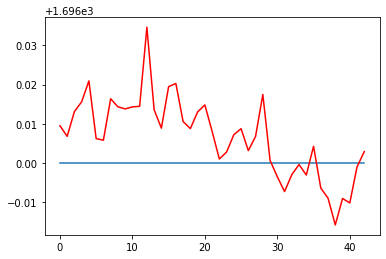

In [152]:
plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()

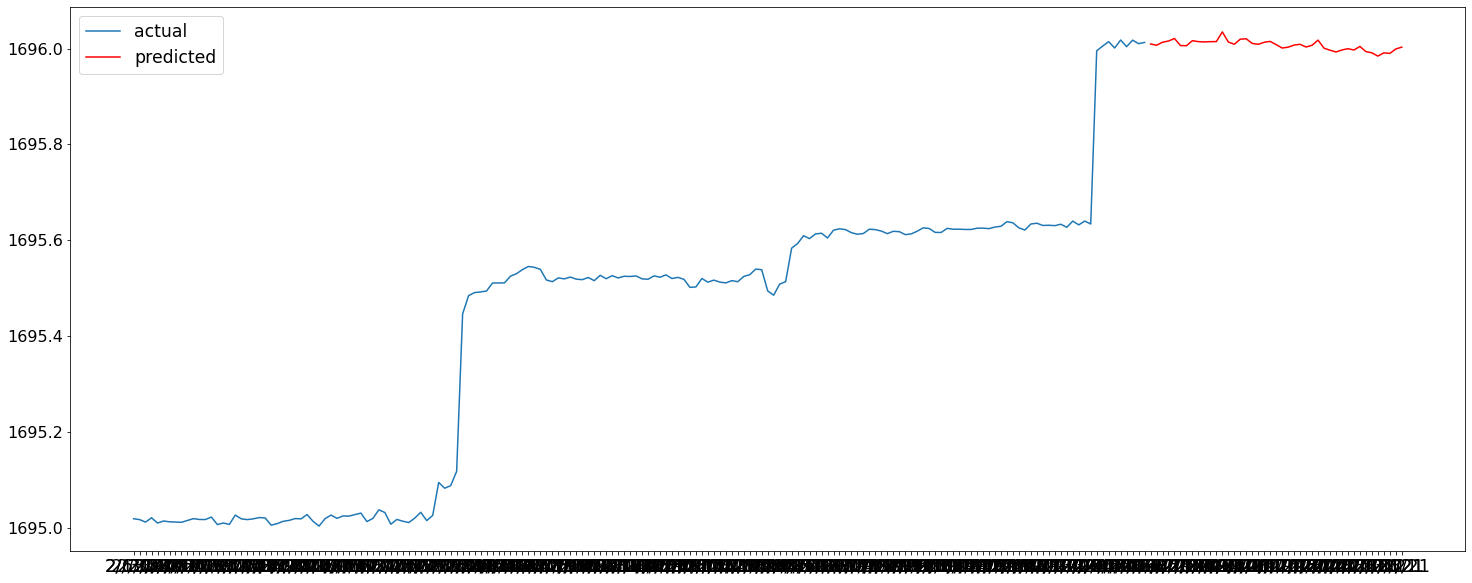

In [153]:
#plotting the graph to show multi step prediction
plt.figure(figsize=(25, 10))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [156]:
len(df_test), len(df_train)

(43, 170)

In [153]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)


In [153]:

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [153]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])